<a href="https://colab.research.google.com/github/khammerberg53/xgboost-loan-default-prediction/blob/main/patientfi_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mljar-supervised==0.11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 5.1 MB/s 
     |████████████████████████████████| 192.9 MB 55 kB/s 
     |████████████████████████████████| 2.0 MB 36.8 MB/s 
     |████████████████████████████████| 76.6 MB 84 kB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 319 kB 53.2 MB/s 
     |████████████████████████████████| 69 kB 7.5 MB/s 
     |████████████████████████████████| 308 kB 54.1 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 209 kB 45.2 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 57.9 MB/s 
     |████████████████████████████████| 147 kB 69.5 MB/s 
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.2-py3-none-any.whl size=146575 

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML

In [ ]:
# reading in the data 
df = pd.read_csv('/gdrive/MyDrive/PatientFI/data.csv')

Columns (18,56) have mixed types.Specify dtype option on import or set low_memory=False.


Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'golden_features', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline logloss 0.835871 trained in 4.81 seconds


Exception while producing SHAP explanations. operands could not be broadcast together with shapes (1000,5) (1000,6) 
Continuing ...


2_DecisionTree logloss 0.153335 trained in 79.0 seconds
Skip default_algorithms because of the time limit.
* Step golden_features will try to check up to 1 model
None 10
Add Golden Feature: funded_amnt_ratio_total_rec_prncp
Add Golden Feature: total_rec_prncp_ratio_funded_amnt
Add Golden Feature: total_rec_prncp_ratio_loan_amnt
Add Golden Feature: loan_amnt_ratio_total_rec_prncp
Add Golden Feature: funded_amnt_inv_ratio_total_rec_prncp
Add Golden Feature: total_rec_prncp_ratio_funded_amnt_inv
Add Golden Feature: funded_amnt_inv_diff_total_rec_prncp
Add Golden Feature: total_pymnt_ratio_installment
Add Golden Feature: collection_recovery_fee_sum_out_prncp_inv
Add Golden Feature: collection_recovery_fee_sum_out_prncp
Created 10 Golden Features in 54.13 seconds.
1_Baseline_GoldenFeatures logloss 0.835871 trained in 59.17 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.153335 trained in 2.84 seconds
AutoML fit time: 162.58 seconds
AutoML best model: 2_DecisionTre

AutoML EDA column limit exceeded! running for first 25 columns
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
Considering 7 the most frequent values
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Considering 7 the most frequent values
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Considering 7 the most frequent values
Mo

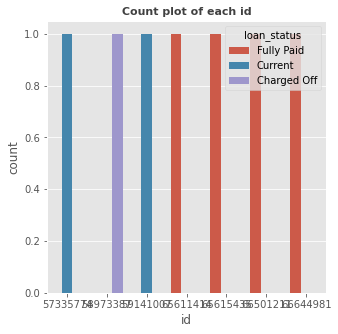

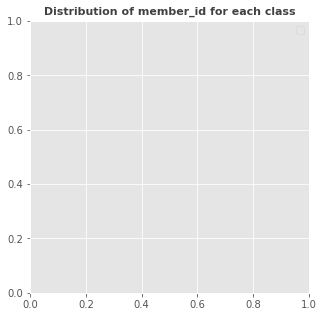

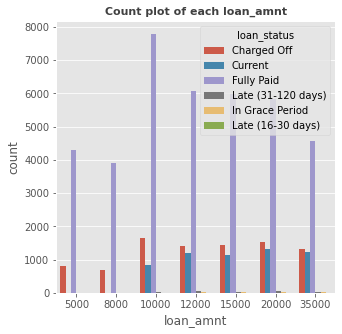

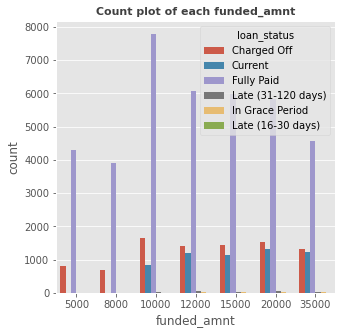

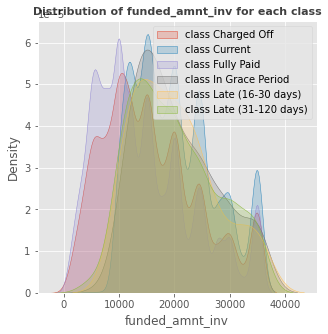

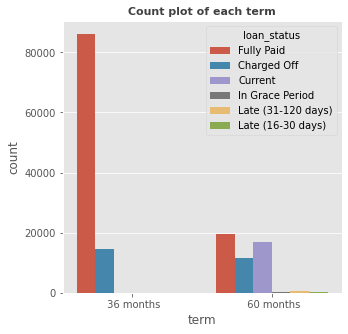

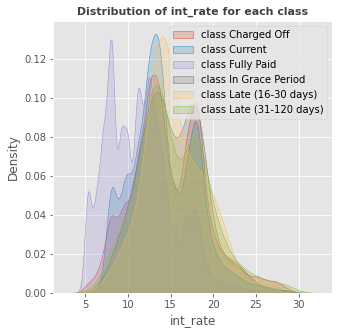

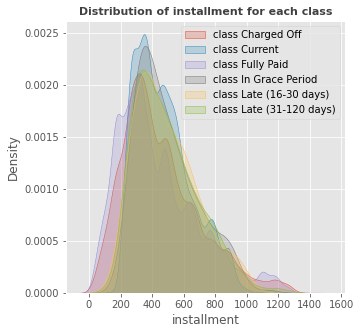

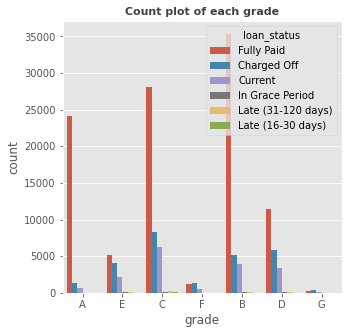

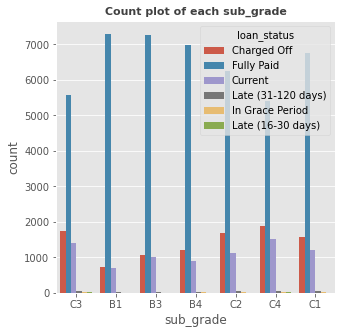

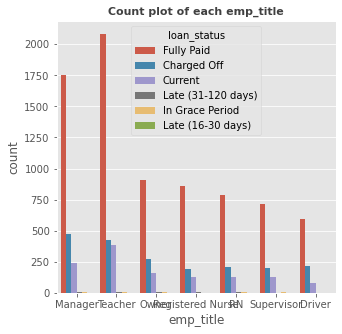

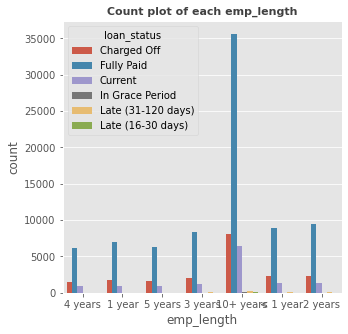

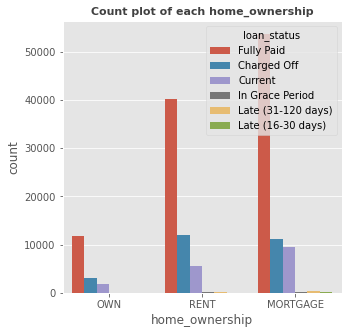

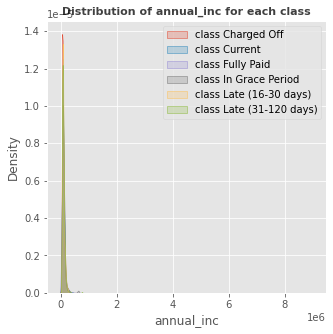

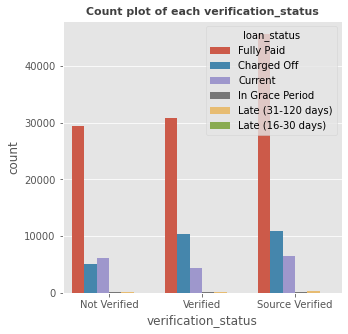

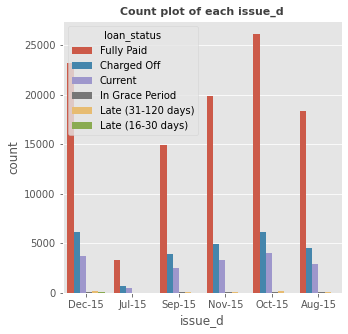

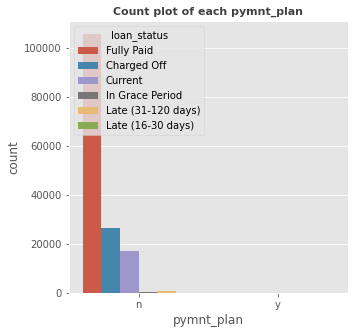

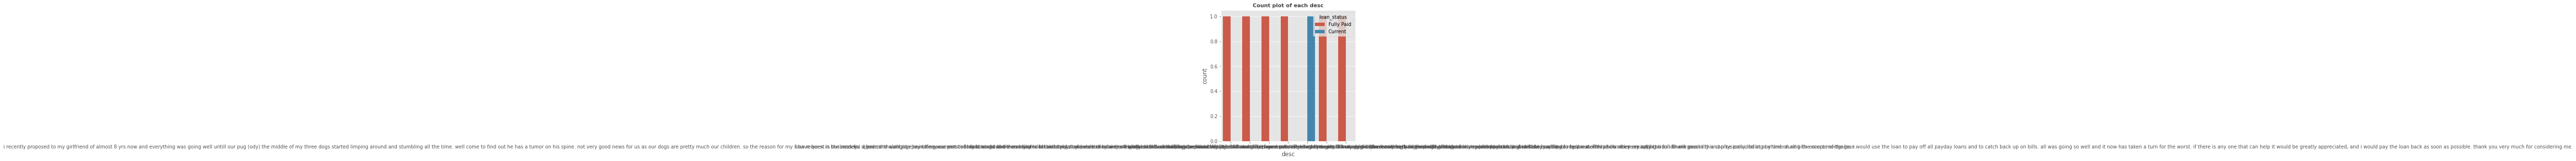

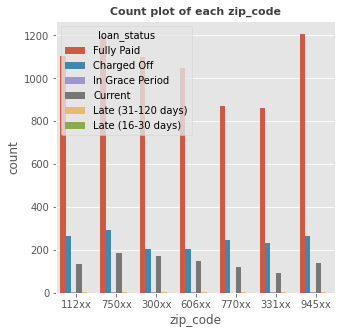

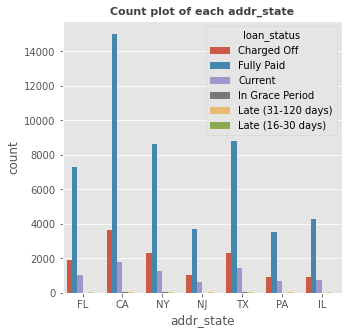

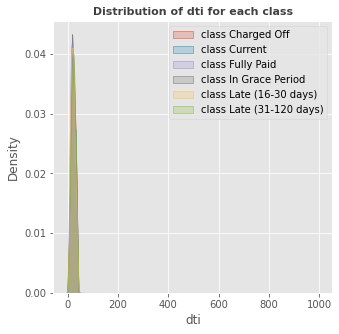

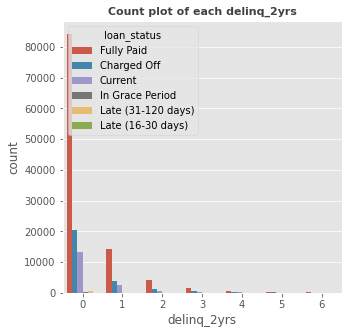

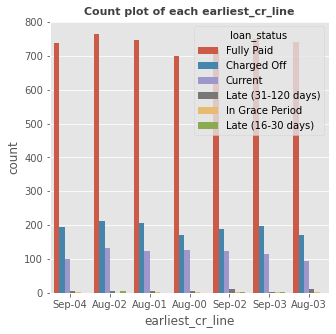

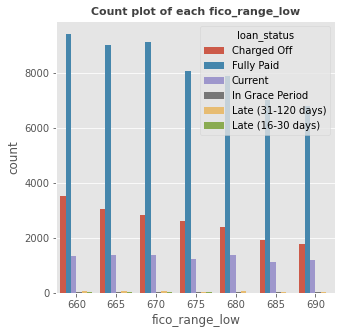

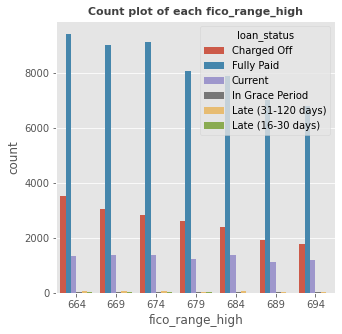

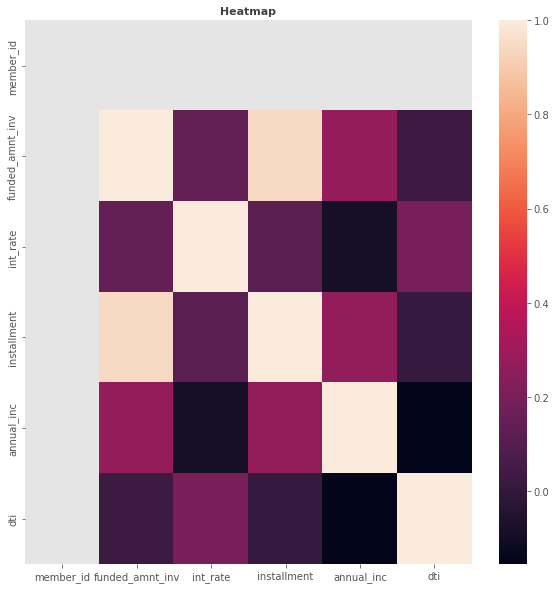

In [ ]:
a = AutoML(total_time_limit=100, mode="Explain", golden_features=True)
a.fit(X_train,y_train)

from supervised.preprocessing.eda import EDA

EDA.extensive_eda(X_train,y_train,save_path="/gdrive/MyDrive/PatientFI/")

In [ ]:
df['loan_status']

0         Fully Paid
1         Fully Paid
2         Fully Paid
3            Current
4         Fully Paid
             ...    
199994    Fully Paid
199995    Fully Paid
199996    Fully Paid
199997    Fully Paid
199998    Fully Paid
Name: loan_status, Length: 199999, dtype: object

In [ ]:
# deleting single observation where home ownership = ANY before test-train split
# also deleting single obs in the target var for 'Default' ... it's messing up my grid search cv
df = df[df['home_ownership'] != 'ANY']
df = df[df['loan_status'] != 'Default']

In [ ]:
X = df.drop(['loan_status'],axis=1)   # independant features
y = df['loan_status']					# dependant variable

In [ ]:
# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# drop cols we know we don't need 
X_test = X_test.drop(['id',
               'member_id',
               'desc',
               'sec_app_fico_range_low',
               'sec_app_fico_range_high',
               'sec_app_earliest_cr_line',
               'sec_app_inq_last_6mths',
               'sec_app_mort_acc',
               'sec_app_open_acc',
               'sec_app_revol_util',
               'sec_app_open_act_il',
               'sec_app_num_rev_accts',
               'sec_app_chargeoff_within_12_mths',
               'sec_app_collections_12_mths_ex_med',
               'sec_app_mths_since_last_major_derog',
               'revol_bal_joint',
               'annual_inc_joint',
               'dti_joint',
               'verification_status_joint',
               'disbursement_method',
               'emp_title'],
              axis=1)

X_train = X_train.drop(['id',
               'member_id',
               'desc',
               'sec_app_fico_range_low',
               'sec_app_fico_range_high',
               'sec_app_earliest_cr_line',
               'sec_app_inq_last_6mths',
               'sec_app_mort_acc',
               'sec_app_open_acc',
               'sec_app_revol_util',
               'sec_app_open_act_il',
               'sec_app_num_rev_accts',
               'sec_app_chargeoff_within_12_mths',
               'sec_app_collections_12_mths_ex_med',
               'sec_app_mths_since_last_major_derog',
               'revol_bal_joint',
               'annual_inc_joint',
               'dti_joint',
               'verification_status_joint',
               'disbursement_method',
               'emp_title'],
              axis=1)

In [ ]:
str_extract = ['term','emp_length','zip_code','earliest_cr_line']

# function to extract strings 
def string_extractor(df, str_extract):
  for column in str_extract:
    df[column] = df[column].str.extract('(\d+)', expand=False)
    df[column] = pd.to_numeric(df[column], errors='coerce')
    print(df[column].head(n=5))
  return df


In [ ]:
# extracting strings from train and test 
X_train = string_extractor(df=X_train, str_extract=str_extract)
X_test = string_extractor(df=X_test, str_extract=str_extract)

21743     36
190848    60
10351     60
135163    36
49971     36
Name: term, dtype: int64
21743     NaN
190848    4.0
10351     1.0
135163    5.0
49971     3.0
Name: emp_length, dtype: float64
21743     301
190848    330
10351      63
135163    214
49971     313
Name: zip_code, dtype: int64
21743     98
190848    96
10351     92
135163    98
49971     10
Name: earliest_cr_line, dtype: int64
134252    36
124138    36
62812     60
66623     36
30075     36
Name: term, dtype: int64
134252    10.0
124138     3.0
62812      1.0
66623      2.0
30075      1.0
Name: emp_length, dtype: float64
134252    850
124138    607
62812     128
66623     329
30075      40
Name: zip_code, dtype: int64
134252     2
124138     0
62812     88
66623      5
30075      6
Name: earliest_cr_line, dtype: int64


In [ ]:
# loop to deal with hardships nan values before encoding 
# for commented out cols, we will let xgboost deal with missing values 
hardship_cols = ['hardship_flag',
                 'hardship_type',
                 'hardship_reason',
                 'hardship_status',
                 'deferral_term',
                 #'hardship_amount',
                 'hardship_start_date',
                 'hardship_end_date',
                 'payment_plan_start_date',
                 #'hardship_length',
                 #'hardship_dpd',
                 'hardship_loan_status',
                 #'hardship_payoff_balance_amount',
                 #'hardship_last_payment_amount'
                 ]

for column in hardship_cols:
  X_train[column].fillna('No Hardship').astype(str)

for column in hardship_cols:
  X_test[column].fillna('No Hardship').astype(str)

In [ ]:
# loop to deal with settlment nan values before encoding 
# for commented out cols (float dtype), we will let xgboost deal with missing values 
settlement_cols = ['debt_settlement_flag',
                   'debt_settlement_flag_date',
                   'settlement_status',
                   'settlement_date',
                   #'settlement_amount',
                   #'settlement_percentage',
                   #'settlement_term'
                   ]

for column in settlement_cols:
  X_train[column].fillna('No Settlement').astype(str)

for column in settlement_cols:
  X_test[column].fillna('No Settlement').astype(str)

In [ ]:
# preparing for ord encoding 
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()

# function to encode ordinal cat vars 
ord_cols = ['grade',
            'sub_grade',
            'issue_d',
            'earliest_cr_line',
            'last_pymnt_d',
            'next_pymnt_d',
            'last_credit_pull_d',
            'hardship_start_date',
            'hardship_end_date',
            'payment_plan_start_date',
            'settlement_date',
            'debt_settlement_flag_date']

def ord_encoder(df, ord_cols):
  for column in ord_cols:
    # assign column to reshaped numpy array
    array = df[column].to_numpy()
    shaped = array.reshape(-1,1)
    #transform data 
    df[column] = encoder.fit_transform(shaped)
    print(df[column].head(n=5))
  return df

In [ ]:
# encoding ordinal vars 
X_train = ord_encoder(df=X_train, ord_cols=ord_cols)
X_test = ord_encoder(df=X_test, ord_cols=ord_cols)

21743     0.0
190848    4.0
10351     4.0
135163    0.0
49971     2.0
Name: grade, dtype: float64
21743      0.0
190848    22.0
10351     20.0
135163     1.0
49971     12.0
Name: sub_grade, dtype: float64
21743     1.0
190848    2.0
10351     1.0
135163    5.0
49971     3.0
Name: issue_d, dtype: float64
21743     57.0
190848    55.0
10351     51.0
135163    57.0
49971     10.0
Name: earliest_cr_line, dtype: float64
21743      8.0
190848     1.0
10351     21.0
135163    17.0
49971      4.0
Name: last_pymnt_d, dtype: float64
21743    NaN
190848   NaN
10351    NaN
135163   NaN
49971    NaN
Name: next_pymnt_d, dtype: float64
21743     32.0
190848    44.0
10351     43.0
135163    29.0
49971     12.0
Name: last_credit_pull_d, dtype: float64
21743    NaN
190848   NaN
10351    NaN
135163   NaN
49971    NaN
Name: hardship_start_date, dtype: float64
21743    NaN
190848   NaN
10351    NaN
135163   NaN
49971    NaN
Name: hardship_end_date, dtype: float64
21743    NaN
190848   NaN
10351    NaN
1351

In [ ]:
# loop to encode dummy cat vars 
one_hot_cols = ['home_ownership',
                'verification_status',
                'addr_state',
                'initial_list_status',
                'application_type',
                'hardship_flag',
                'hardship_type',
                'hardship_reason',
                'hardship_status',
                'deferral_term',
                'hardship_loan_status',
                'debt_settlement_flag',
                'settlement_status',
                'pymnt_plan',
]

def one_hot_encoder(df, one_hot_cols):
  for column in one_hot_cols:
      tempdf = pd.get_dummies(df[column], prefix=column)
      df = pd.merge(
          left=df,
          right=tempdf,
          left_index=True,
          right_index=True,
      )
      df = df.drop(columns=column)
  return df

In [ ]:
# encoding dummies 
X_train = one_hot_encoder(df=X_train, one_hot_cols=one_hot_cols)
X_test = one_hot_encoder(df=X_test, one_hot_cols=one_hot_cols)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.metrics import accuracy_score


#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgb = XGBClassifier(objective='multi:softmax',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          verbosity=1)
xgb.fit(X_train , y_train)

#extracting default parameters from benchmark model
#default_params = {}
#gparams = xgb.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
'''
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]
'''


parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

#GS
clf0 = GridSearchCV(estimator=xgb, scoring='accuracy', param_grid=parameters, return_train_score=True, verbose=3, cv=5)
clf0.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)


#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)


#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)


#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1, average='micro')
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0, average='micro')
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1, average='micro')
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0, average='micro')


#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test), multi_class='ovr')

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=(train=0.982, test=0.982) total time=  43.2s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=(train=0.982, test=0.982) total time=  40.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=(train=0.982, test=0.981) total time=  42.5s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=(train=0.982, test=0.982) total time=  40.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=60;, score=(train=0.982, test=0.981) total time=  41.5s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.988, test=0.989) total time= 1.1min
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.988, test=0.988) total time= 1.1min
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.988, test=0.988) total time= 1.1min
[CV 4/5] END learning_r

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [ ]:
clf0.best_estimator_

XGBClassifier(eval_metric='auc', grow_policy='lossguide', max_depth=7,
              n_estimators=180, objective='multi:softprob', tree_method='hist',
              use_label_encoder=False)

In [ ]:
results_dict['xgbc0']

{'best_params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 180},
 'cfm_test': array([[ 8695,     0,    64,     0,     0,     0],
        [    0,  5680,     0,     2,     1,     1],
        [    3,     0, 35223,     0,     0,     0],
        [    0,    95,     0,     0,     1,     1],
        [    0,    34,     0,     1,     0,     1],
        [    0,    51,     0,     1,     0,   146]]),
 'cfm_train': array([[ 26326,      0,      5,      0,      0,      0],
        [     0,  16953,      0,      0,      0,      0],
        [     0,      0, 105764,      0,      0,      0],
        [     0,      0,      0,    250,      0,      0],
        [     0,      0,      0,      0,    112,      0],
        [     0,      0,      0,      0,      0,    587]]),
 'classifier': GridSearchCV(cv=5,
              estimator=XGBClassifier(eval_metric='auc', grow_policy='lossguide',
                                      objective='multi:softprob',
                                      tree_method='h

In [ ]:
# fitting the model 
RANDOM_STATE = 1234
xgb = XGBClassifier(objective='multi:softprob',
                    eval_metric='auc',
                    grow_policy='lossguide',
                    max_depth = 7,
                    n_estimators = 180,
                    use_label_encoder = False,
                    random_state=RANDOM_STATE,
                    tree_method='hist',
                    verbosity=2)
model = xgb.fit(X_train, y_train)

[17:24:56] INFO: /workspace/src/learner.cc:215: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[17:24:58] INFO: /workspace/src/tree/updater_quantile_hist.cc:63: Generating gmat: 2.36797 sec
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=7
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=7
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=7
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[17:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

In [ ]:
# predicting on the test set 
y_pred = xgb.predict(X_test)

In [ ]:
# checking acc 
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" %(acc*100.0))

Accuracy: 99.49%


In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)


array([[ 8695,     0,    64,     0,     0,     0],
       [    0,  5680,     0,     2,     1,     1],
       [    3,     0, 35223,     0,     0,     0],
       [    0,    95,     0,     0,     1,     1],
       [    0,    34,     0,     1,     0,     1],
       [    0,    51,     0,     1,     0,   146]])

In [ ]:
cls = np.unique(y_test)
print(cls)

class_accuracies = []
for class_ in np.unique(y_test):
    class_acc = np.mean(y_pred[y_test == class_] == class_)
    class_accuracies.append(class_acc)

['Charged Off' 'Current' 'Fully Paid' 'In Grace Period'
 'Late (16-30 days)' 'Late (31-120 days)']


In [ ]:
class_accuracies

[0.9926932298207558,
 0.9992962702322308,
 0.9999148356327713,
 0.0,
 0.0,
 0.7373737373737373]

The goal of the project was to predict the label "Charged Off." The model was able to correctly predict it 99.3% of the time, along with correctly predicting "Current" 99.9% of the time, and "Fully Paid" 99.9% of the time. 